In [1]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import time
from typing import Sequence, Union, Optional, Any

import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import nltk
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.stats import reciprocal

from sklearn.pipeline import Pipeline
from nft_analyser.transformers import *
from nft_analyser import helper

# Downgrade to sklearn==0.21.2 for RandomizedSearchCV with keras

Using TensorFlow backend.


In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/gskgagan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gskgagan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/gskgagan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Analysis

In [3]:
default_params = {
    'glove_features': 300,
    'nft_value_range': [0.1, 1e4],      # 10c to $10k
    'value_aggregation': ['mean'],
    'include_nft_age': True,            # Takes long time (10% out of sample improvement)
    'drop_na_age': False,
    'learning_rate': 0.8,
    'epochs': 100
}

### Vector representation of NFT names using pretrained Glove

In [4]:
# Convert NFT Names to Vectors
nft_df = helper.get_table("nfts").set_index('address')      # Multiple calls ok as cached at helper level
glove_df = helper.get_glove(features=default_params['glove_features'])

nft_vec_pp: Pipeline = Pipeline([
    ('selectColumns', SelectColumns(columns='name')),
    ('onlyFirstCapital', CamelCaseFirstCapital()),
    ('camelToWords', CamelCaseToWords()),
    ('cleanText', CleanText(regex=r'[^a-zA-Z0-9\$]')),
    ('tokenize', Tokenize()),
    ('removeStopWords', RemoveStopWords(nltk.corpus.stopwords.words('english'))),
    ('lemmatize', Lemmatize(lemmatizer=nltk.WordNetLemmatizer())),
    ('explodeList', ExplodeList()),
    ('gloveFeatures', Vectorize(column='name', vectorization_df=glove_df, ignore_missing=True))
])

nft_vec_df = nft_vec_pp.fit_transform(nft_df)

### Linking NFT vector to Transaction Data

In [6]:
# Transaction Data
trans_df = helper.get_table('transfers')
df = trans_df[['nft_address', 'transaction_value']]
df['transaction_value'] = df.transaction_value * 3e3 / 1e18   # To USD
df = df[(df.transaction_value > default_params['nft_value_range'][0]) & 
        (df.transaction_value < default_params['nft_value_range'][1])]
transaction_df = df.groupby('nft_address').agg({'transaction_value': default_params['value_aggregation']})
transaction_df.columns = [c[1] for c in transaction_df.columns]

In [7]:
# Analysis Data - NFT vectors to transaction values
analysis_df = transaction_df.join(nft_vec_df, how='inner')
if default_params['include_nft_age']:
    time_df = helper.get_table('mints')
    time_df = time_df[['nft_address', 'timestamp']]
    time_df = time_df.groupby('nft_address').min()
    time_df = (time.time() - time_df) / (3600*24)
    analysis_df = analysis_df.join(time_df)
    if default_params['drop_na_age']:
        analysis_df = analysis_df.dropna()
    else:
        analysis_df = analysis_df.fillna(0.0)

## Fitting Neural Network

In [8]:
# Neural Network Definition
def hyper_neural_network(input_shape:int, output_shape:int, num_layers:int, num_neurons:int, connect_input:bool, 
                         loss_fn:str, learning_rate:float) -> keras.Model:
    input_ = keras.layers.Input(shape=(input_shape,))
    last_ = input_
    for _ in range(num_layers):
        last_ = keras.layers.Dense(num_neurons, activation='relu')(last_)
    if connect_input:
        last_ = keras.layers.Concatenate()([input_, last_])
    output_ = keras.layers.Dense(output_shape, activation='relu')(last_)    # Positive $ values only
    
    model = keras.Model(inputs=[input_], outputs=[output_])
    model.compile(loss=loss_fn, optimizer=keras.optimizers.Adam(lr=learning_rate))
    return model

In [9]:
y_cols = default_params['value_aggregation']
X, y = analysis_df[[c for c in analysis_df.columns if c not in y_cols]], analysis_df[y_cols]

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)
train_t, val_t, test_t = (X_train, y_train), (X_valid, y_valid), (X_test, y_test)

In [10]:
# Performing Randomized Parameter Search on Neural Network
input_shape, output_shape = train_t[0].shape[1], train_t[1].shape[1]

model_reg = keras.wrappers.scikit_learn.KerasRegressor(hyper_neural_network,
                input_shape=input_shape, output_shape=output_shape, 
                num_layers=3, num_neurons=30, connect_input=True,
                loss_fn='mae', learning_rate=default_params['learning_rate'])
params_dist = {
    'num_layers': [1, 2, 3, 4],
    'num_neurons': np.arange(1, 100, 5),
    'connect_input': [True, False],
    'loss_fn': ['mse'],
    'learning_rate': reciprocal(3e-4, 3e-2)
}
rnd_search_cv = RandomizedSearchCV(model_reg, params_dist, n_iter=10, cv=3)        
rnd_search_cv.fit(*train_t, epochs=default_params['epochs'], 
                    validation_data=val_t,    # Used for early stoppage
                    callbacks=[keras.callbacks.EarlyStopping(patience=10)])

/Users/gskgagan/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/gskgagan/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, us

Train on 2583 samples, validate on 1292 samples
Epoch 1/100
2583/2583 [==============================] - 1s 401us/step - loss: 3067264.7000 - val_loss: 2920532.8653
Epoch 2/100
2583/2583 [==============================] - 0s 161us/step - loss: 2560653.4533 - val_loss: 2856606.8545
Epoch 3/100
2583/2583 [==============================] - 0s 156us/step - loss: 2432346.2879 - val_loss: 2666685.3220
Epoch 4/100
2583/2583 [==============================] - 0s 154us/step - loss: 2362072.0629 - val_loss: 2648698.2446
Epoch 5/100
2583/2583 [==============================] - 0s 147us/step - loss: 2299581.8849 - val_loss: 2659703.2067
Epoch 6/100
2583/2583 [==============================] - 0s 172us/step - loss: 2226484.0717 - val_loss: 2638031.2601
Epoch 7/100
2583/2583 [==============================] - 0s 146us/step - loss: 2184196.7304 - val_loss: 2666690.2570
Epoch 8/100
2583/2583 [==============================] - 0s 153us/step - loss: 2097503.2056 - val_loss: 2676677.6200
Epoch 9/100
2583

/Users/gskgagan/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:793: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


Train on 3875 samples, validate on 1292 samples
Epoch 1/100
3875/3875 [==============================] - 1s 272us/step - loss: 3516557.9159 - val_loss: 3632021.2353
Epoch 2/100
3875/3875 [==============================] - 1s 166us/step - loss: 3164743.1124 - val_loss: 3106705.3545
Epoch 3/100
3875/3875 [==============================] - 1s 159us/step - loss: 2867857.8161 - val_loss: 3018568.9373
Epoch 4/100
3875/3875 [==============================] - 1s 145us/step - loss: 2822880.1626 - val_loss: 2978589.4420
Epoch 5/100
3875/3875 [==============================] - 1s 155us/step - loss: 2770469.8108 - val_loss: 2922002.2376
Epoch 6/100
3875/3875 [==============================] - 1s 168us/step - loss: 2706947.4685 - val_loss: 2863372.8197
Epoch 7/100
3875/3875 [==============================] - 1s 171us/step - loss: 2643327.5403 - val_loss: 2804531.4420
Epoch 8/100
3875/3875 [==============================] - 1s 154us/step - loss: 2584162.5103 - val_loss: 2760346.4899
Epoch 9/100
3875

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7ff3dd5cfa10>,
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'connect_input': [True, False],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff3dd5cfa50>,
                                        'loss_fn': ['mse'],
                                        'num_layers': [1, 2, 3, 4],
                                        'num_neurons': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81,
       86, 91, 96])},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [11]:
print("Best Params:")
print(rnd_search_cv.best_params_)
print(f"Best Score: {rnd_search_cv.best_score_}")

Best Params:
{'connect_input': False, 'learning_rate': 0.0003068775487284945, 'loss_fn': 'mse', 'num_layers': 3, 'num_neurons': 36}
Best Score: -2500601.467032258


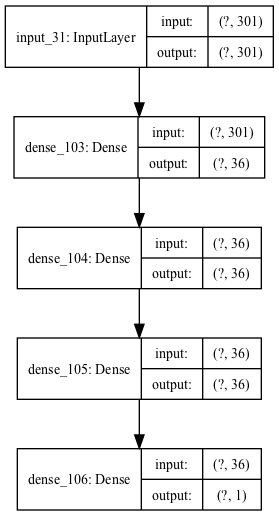

In [27]:
best_model = rnd_search_cv.best_estimator_.model
tf.keras.utils.plot_model(best_model, show_shapes=True)

## Name Comparison Class

In [12]:
class CompareName:
    def __init__(self, vec_pp, pred_model, glove_df, include_age):
        self.vec_pp = vec_pp
        self.pred_model = pred_model
        self.glove_df = glove_df
        self.glove_set = set(glove_df.index)
        self.include_age = include_age

    def _get_vec_df(self, words: Sequence[str], include_age: bool=False):
        # unmappable = {w.lower() for w in words} - self.glove_set
        # if len(unmappable) != 0:
        #     raise Exception(f'The following words cannot be analyzed: {unmappable}')
        df = pd.DataFrame({'name': words}, index=words)
        df = self.vec_pp.transform(df)
        if include_age:
            df['timestamp'] = 0.0
        return df
    
    def get_value(self, words: Sequence[str]):
        df = self._get_vec_df(words, self.include_age)
        return pd.DataFrame(self.pred_model.predict(df), index=df.index, columns=['est_value'])
        
    def get_similar(self, words: Sequence[str], limit: int=10):
        df = self._get_vec_df(words)
        sim_score_df = self.glove_df @ df.T
        return sim_score_df.apply(lambda col_ss: col_ss.sort_values(ascending=False)[:limit].index.values)

    def get_similar_value(self, words: Sequence[str], limit: int=10):
        sim_df = self.get_similar(words, limit=limit)
        res_sss = {}
        for c in sim_df.columns:
            res_sss[c] = self.get_value(sim_df[c].values).sort_values(ascending=False, by='est_value').index
        res_df = pd.DataFrame(res_sss)
        res_df.index = pd.Index(data=range(1, limit+1), name='rank')
        return res_df

In [23]:
    compare = CompareName(nft_vec_pp, best_model, glove_df, default_params['include_nft_age'])
    words = ['Apple', 'Mango', 'Banana', 'Kittens', 'Dog', 'Ape']
    compare.get_value(words).sort_values('est_value', ascending=False)

,est_value
Apple,2185.186279
Dog,2041.325562
Ape,1901.707153
Kittens,1501.318604
Mango,1056.713135
Banana,575.959412


In [24]:
# Suggestion on which alternative words can be used
compare.get_similar_value(words, limit=10)

,Apple,Mango,Banana,Kittens,Dog,Ape
rank,,,,,,
1,iphone,cucumber,peanut,cute,dog,homo
2,ipad,tomato,mango,puppy,dogs,ape
3,ipod,mango,fruit,puppies,hound,apes
4,apple,apricot,papaya,cat,puppy,tarzan
5,microsoft,guava,avocado,kitten,cat,frog
6,google,chutney,sugar,kittens,pet,chimpanzee
7,macintosh,papaya,coconut,tabby,sled,monkey
8,itunes,avocado,pineapple,puss,horse,hairy
9,intel,coconut,banana,gisbergen,animal,creature
